# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [5]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# data cleaning
import missingno as msno

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split

In [6]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

/tmp/ipykernel_41007/2212289888.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


In [7]:
d.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            200000 non-null  int64  
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  float64
 5   mi_pct          200000 non-null  int64  
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            200000 non-null  int64  
 9   dti             200000 non-null  int64  
 10  orig_upb        200000 non-null  int64  
 11  ltv             200000 non-null  int64  
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

In [8]:
# Based on the data dictionary, manually specify categorical and numerical columns
# 将数据分为数值变量和类别变量
# 这里舍弃了ID和loan_status这些非自变量列名，直接删去了ppnt_pnlty、prod_type和io_ind这三个列因为他们三列对应的所有贷款都只有一个单一值对建模无意义
categorical_columns = [
    'flag_fthb', 'occpy_sts', 'channel', 'st',
    'prop_type', 'zipcode', 'loan_purpose', 'seller_name',
    'servicer_name', 'flag_sc', 'program_ind', 'rr_ind',
    'cd_msa', 'cnt_borr', 
    'property_val', 'mi_cancel_ind','cnt_units'
]

numerical_columns = [
    'fico', 'dt_first_pi', 'dt_matr',  'mi_pct',
     'cltv', 'dti', 'orig_upb', 'ltv',
    'int_rt', 'orig_loan_term'
]

# Optional: Convert categorical columns to 'object' dtype for consistency
d[categorical_columns] = d[categorical_columns].astype("object")

# Print preview
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)


Categorical Columns: ['flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'zipcode', 'loan_purpose', 'seller_name', 'servicer_name', 'flag_sc', 'program_ind', 'rr_ind', 'cd_msa', 'cnt_borr', 'property_val', 'mi_cancel_ind', 'cnt_units']
Numerical Columns: ['fico', 'dt_first_pi', 'dt_matr', 'mi_pct', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']


/tmp/ipykernel_41007/1060522820.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d[col] = d[col].replace(missing_vals, np.nan)


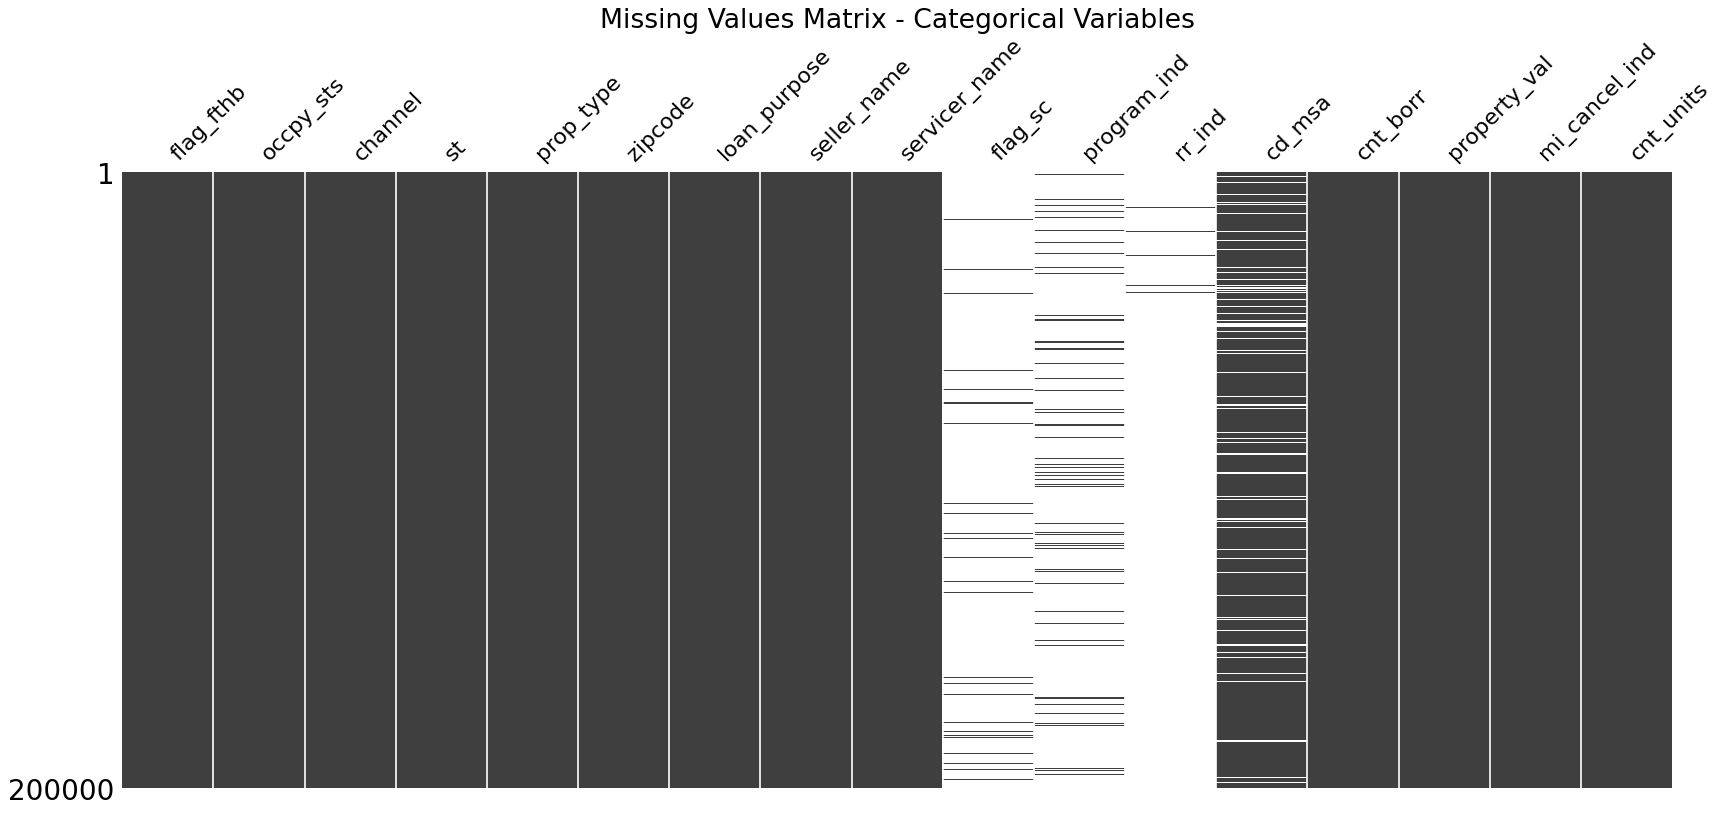

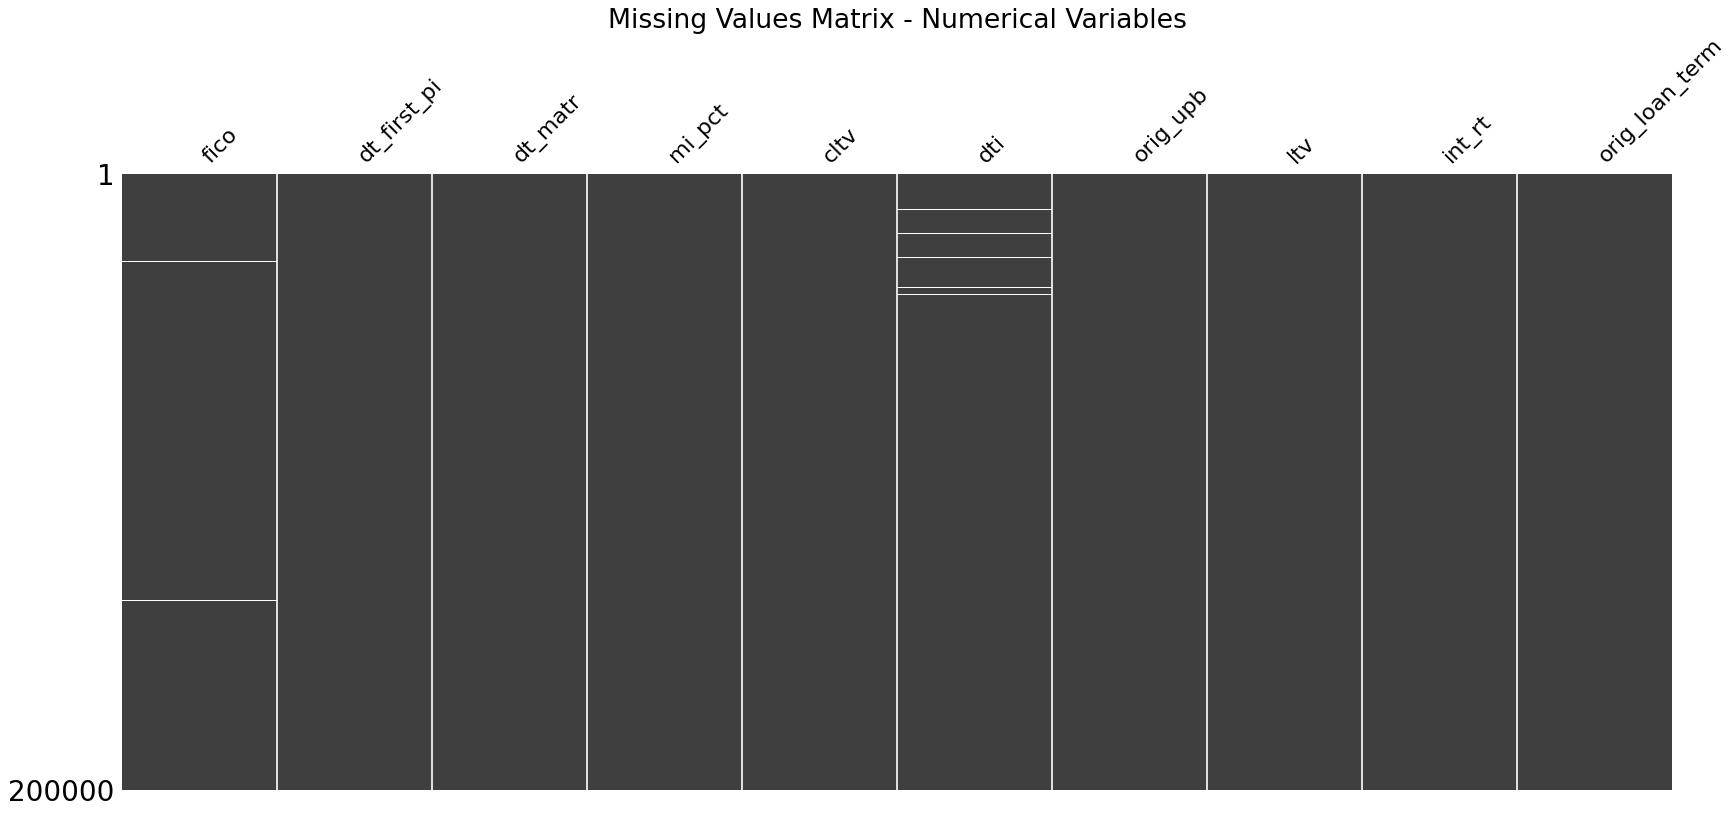

In [9]:
# 替换特定值为缺失值 NaN（根据数据字典中的定义） 方便画图
missing_value_map = {
    'fico': [9999],
    'mi_pct': [999],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'flag_fthb': ['9'],
    'occpy_sts': ['9'],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'rr_ind': ['9'],
    'cnt_borr': ['9'],
    'property_val': ['9'],
    'mi_cancel_ind': ['9'],
    'cnt_units': ['99']
}

# 替换操作
for col, missing_vals in missing_value_map.items():
    d[col] = d[col].replace(missing_vals, np.nan)

# 画类别变量的缺失图
msno.matrix(d[categorical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Categorical Variables", fontsize = 24)
plt.show()

# 画数值变量的缺失图
msno.matrix(d[numerical_columns], fontsize=20, sparkline=False)
plt.title("Missing Values Matrix - Numerical Variables", fontsize = 24)
plt.show()


通过分析我们发现大部分数据没有空值不需要填充，但是还是存在一些有空值的现象需要填充数据。
在这里我们填充数据的逻辑是：
1. 空值过多，直接删去这1列
2. 空值不多，分布呈现正态分布，我们对所有空值取mean
3. 空值不多，分布呈现偏态，我们对所有空值取median
4. 对于类别变量，对于有些列，我们直接取median（即最多的列）
5. 对于部分有特殊含义的类别变量，我们添加一个类别专门用来表示missing

具体填补操作
1. fico 呈现偏态分布，使用median填补空值
2. cd_msa 空值可能是非大都市区域，我们给空值添加一个missing类别
3. mi_pct 只有一个空，直接删去
4. cltv 只有6个空，直接删去
5. dti 偏态，median 填充
6. ltv 只有两个空，直接删去
7. flag_sc 空值的意义是否，添加新类别 将空值的类别设置为否
8. id_loan_rr 后面不用，不管
9. program_ind 空值可能有意义，加为新的missing类别
10. rr_ind 空值的意义是否，添加新类别 将空值的类别设置为否

In [10]:
# 填补空值
# 1. fico：中位数填补（偏态分布）
d['fico'] = d['fico'].fillna(d['fico'].median())

# 2. cd_msa：新增一个类别 "missing"
d['cd_msa'] = d['cd_msa'].fillna('missing')

# 3. mi_pct：删除空值所在行
d = d[d['mi_pct'].notna()]

# 4. cltv：删除空值所在行
d = d[d['cltv'].notna()]

# 5. dti：中位数填补（偏态分布）
d['dti'] = d['dti'].fillna(d['dti'].median())

# 6. ltv：删除空值所在行
d = d[d['ltv'].notna()]

# 7. flag_sc：空值设为 'N'（表示否）
d['flag_sc'] = d['flag_sc'].fillna('N')

# 9. program_ind：空值设为新类别 'missing'
d['program_ind'] = d['program_ind'].fillna('missing')

# 10. rr_ind：空值设为 'N'（表示否）
d['rr_ind'] = d['rr_ind'].fillna('N')

data_labeled = d[d['loan_status'].isin(['default', 'prepaid'])]

data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)

# 3. 定义用于建模的特征变量（你之前分好的数值 + 类别变量）
feature_columns = categorical_columns + numerical_columns

# 4. 构建特征 X 与标签 y
# X = data_labeled[feature_columns]
# y = data_labeled['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

/tmp/ipykernel_41007/384729732.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled['target'] = (data_labeled['loan_status'] == 'default').astype(int)


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [21]:
data_labeled.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status,target
0,809.0,201705,N,204704,missing,0.0,1,P,75.0,38.0,...,SPECIALIZED LOAN SERVICING LLC,N,NaN,missing,N,2,N,7,prepaid,0
2,792.0,201703,N,204702,missing,0.0,1,S,60.0,36.0,...,Other servicers,N,NaN,missing,N,2,N,7,prepaid,0
3,776.0,201703,N,204702,missing,0.0,1,S,80.0,18.0,...,Other servicers,N,NaN,missing,N,2,N,7,prepaid,0
6,687.0,201703,N,204702,46520.0,0.0,1,P,80.0,45.0,...,Other servicers,N,NaN,missing,N,2,N,7,prepaid,0
7,758.0,201703,N,203202,missing,0.0,1,P,53.0,36.0,...,Other servicers,N,F05Q10205970,missing,Y,3,N,7,prepaid,0


In [22]:
data_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126703 entries, 0 to 199986
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            126703 non-null  float64
 1   dt_first_pi     126703 non-null  int64  
 2   flag_fthb       126703 non-null  object 
 3   dt_matr         126703 non-null  int64  
 4   cd_msa          126703 non-null  object 
 5   mi_pct          126703 non-null  float64
 6   cnt_units       126703 non-null  int64  
 7   occpy_sts       126703 non-null  object 
 8   cltv            126703 non-null  float64
 9   dti             126703 non-null  float64
 10  orig_upb        126703 non-null  int64  
 11  ltv             126703 non-null  float64
 12  int_rt          126703 non-null  float64
 13  channel         126703 non-null  object 
 14  ppmt_pnlty      126703 non-null  object 
 15  prod_type       126703 non-null  object 
 16  st              126703 non-null  object 
 17  prop_type      

In [23]:
# 统计 target 变量的总体分布
target_counts = data_labeled['target'].value_counts()
print("Target counts:")
print(target_counts)
print("\nTarget proportions:")
print(target_counts / len(data_labeled))

Target counts:
target
0    125957
1       746
Name: count, dtype: int64

Target proportions:
target
0    0.994112
1    0.005888
Name: count, dtype: float64


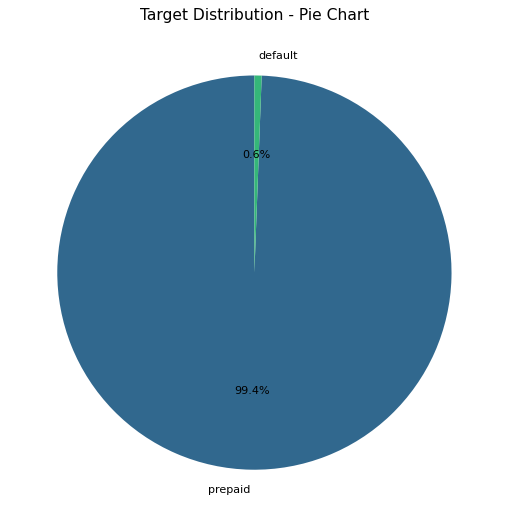

In [11]:
# 绘制饼图
plt.figure(figsize=(8, 8))
colors = sns.color_palette("viridis", len(target_counts))
plt.pie(target_counts.values, labels=['prepaid', 'default'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Target Distribution - Pie Chart', fontsize=14)
plt.show()

着重解决提前还贷和推迟还贷样本数极不平衡的问题

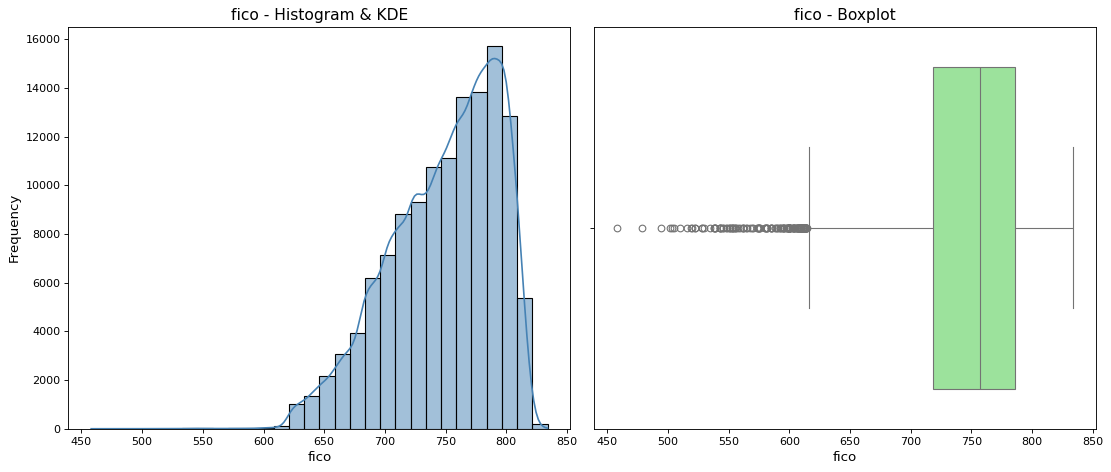

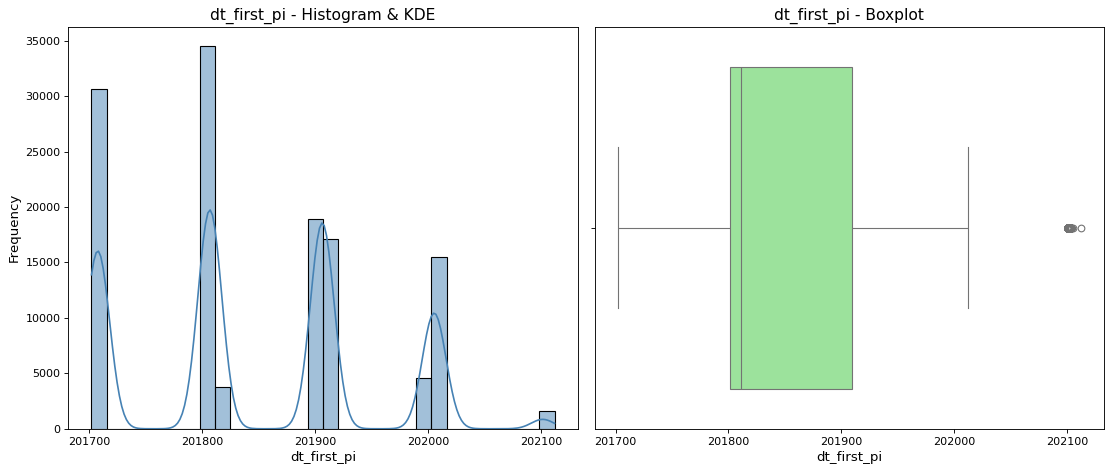

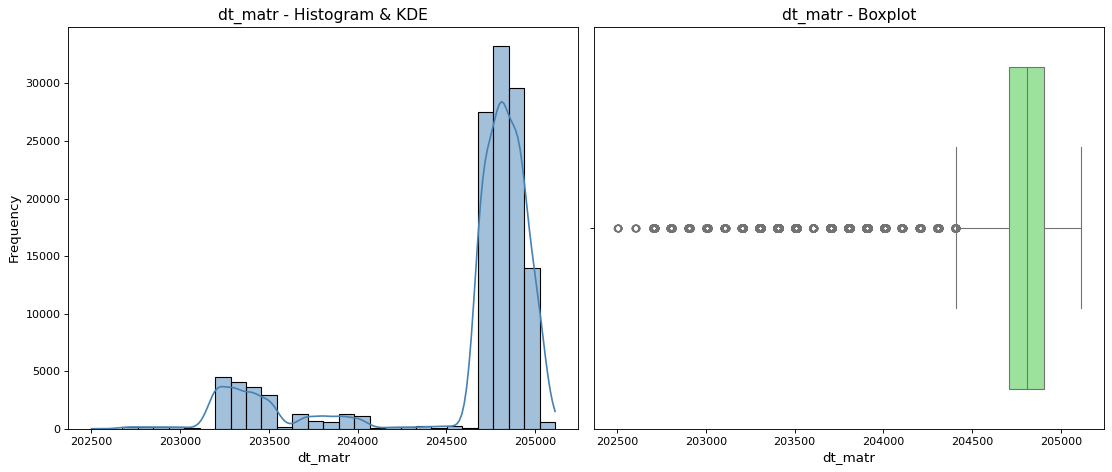

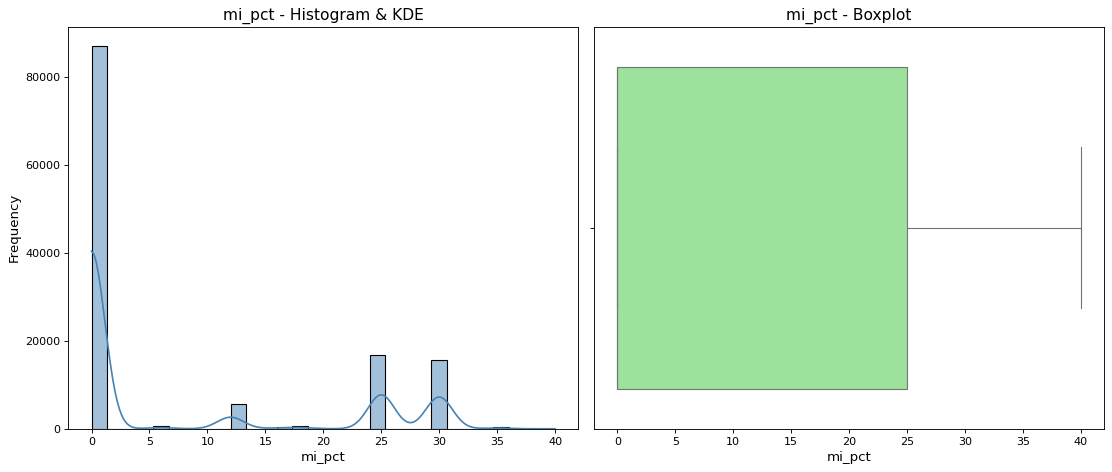

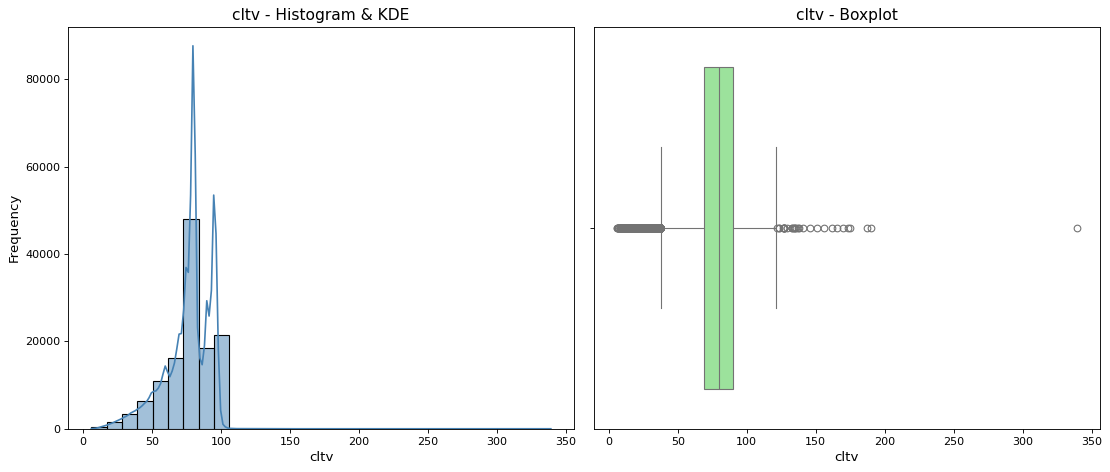

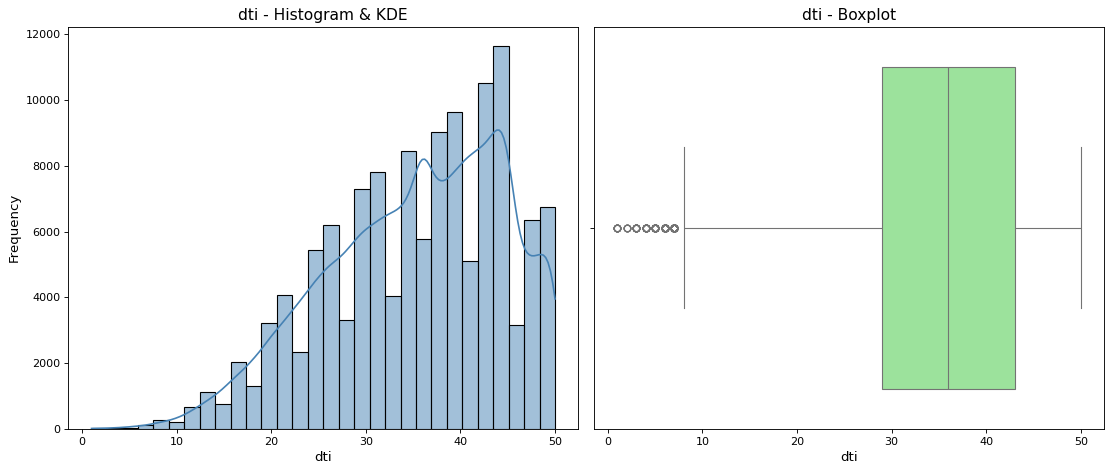

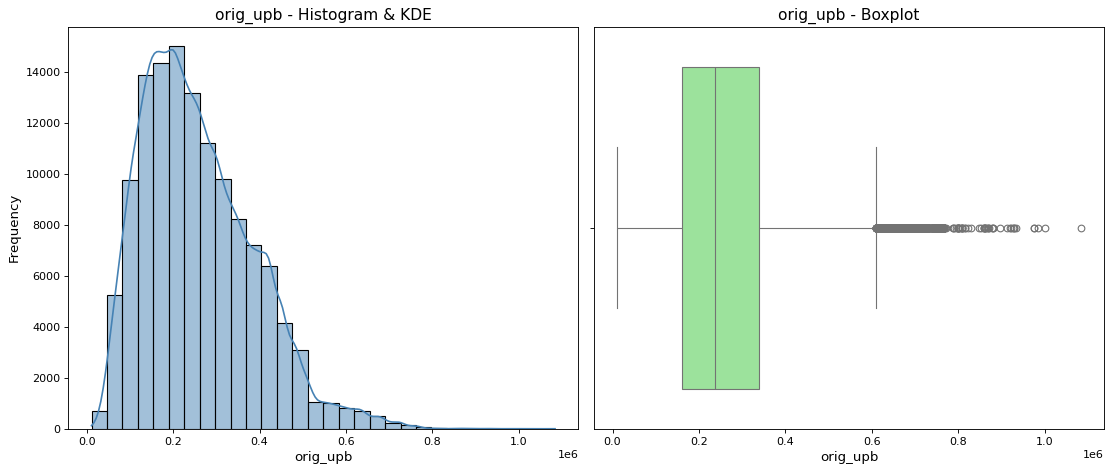

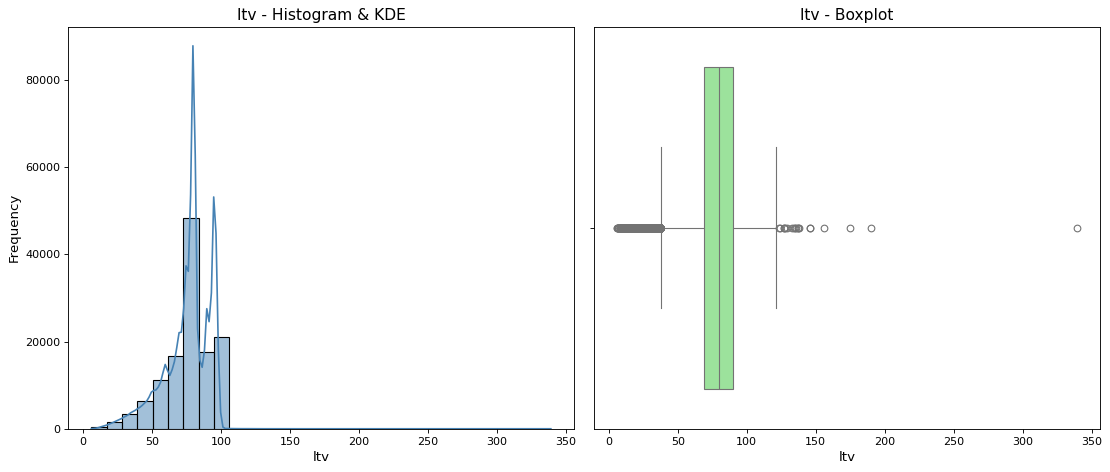

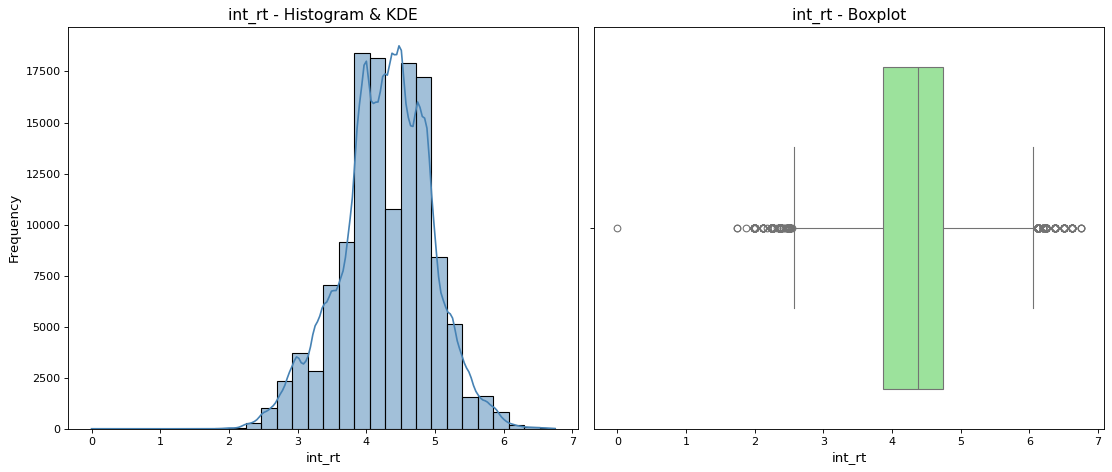

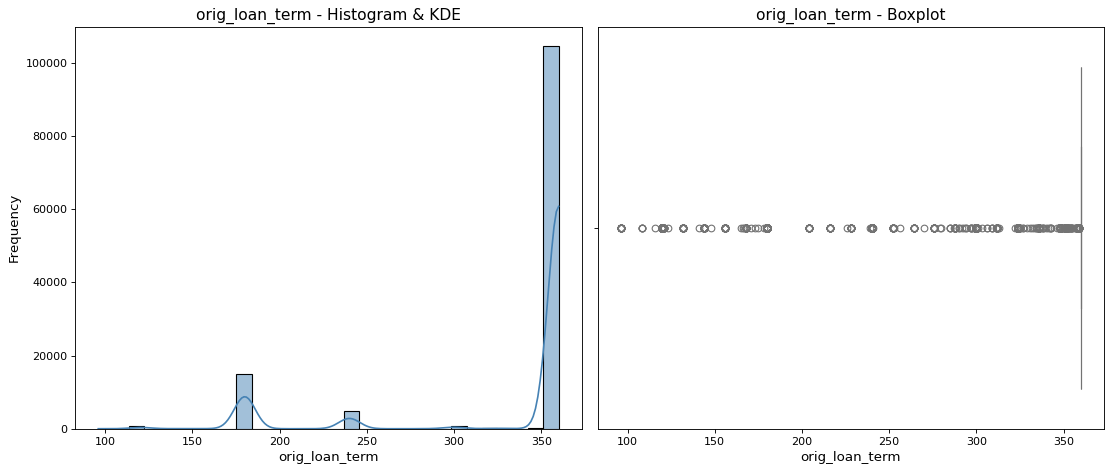

In [12]:
# 数值变量的描述性统计与分布分析
for col in numerical_columns:
    plt.figure(figsize=(14, 6))
    
    # 绘制直方图及核密度估计
    plt.subplot(1, 2, 1)
    sns.histplot(data_labeled[col], kde=True, bins=30, color='steelblue')
    plt.title(f'{col} - Histogram & KDE', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # 绘制箱线图，检查异常值与分布
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_labeled[col], color='lightgreen')
    plt.title(f'{col} - Boxplot', fontsize=14)
    plt.xlabel(col, fontsize=12)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


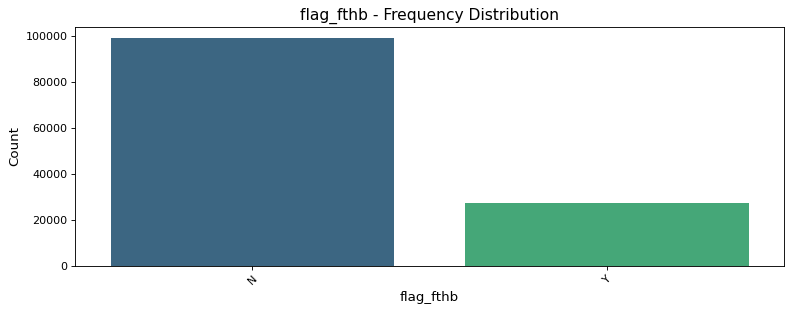

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


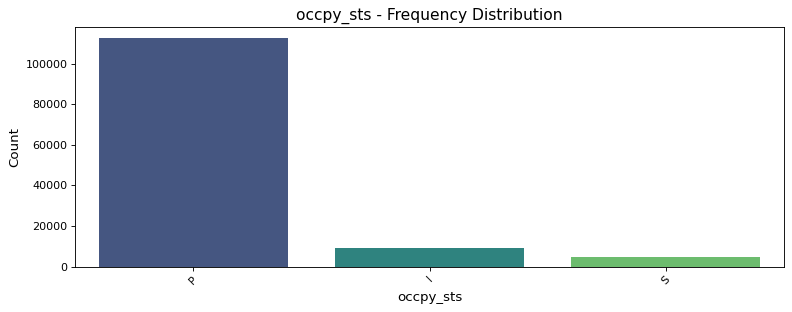

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


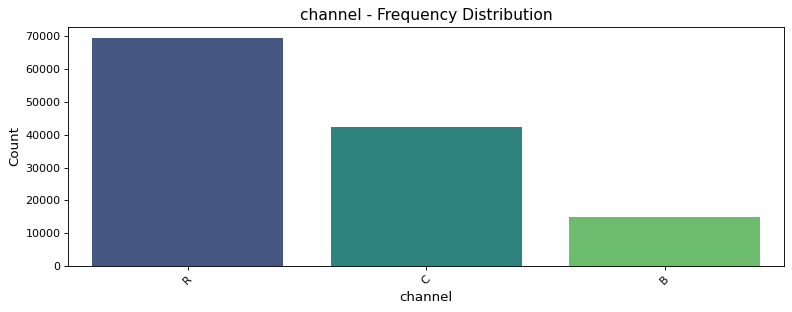

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


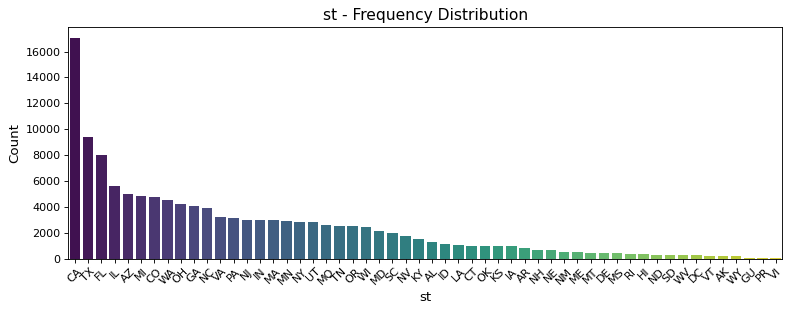

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


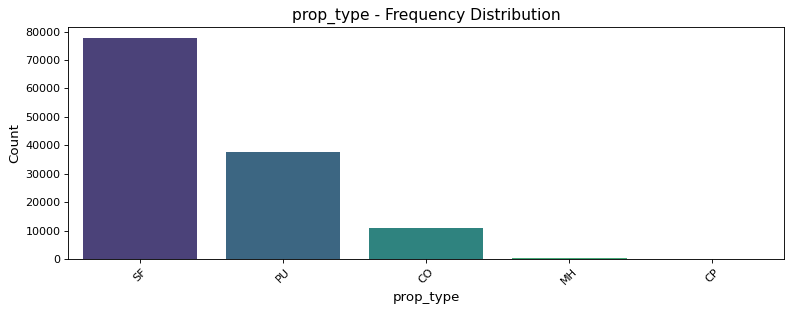

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


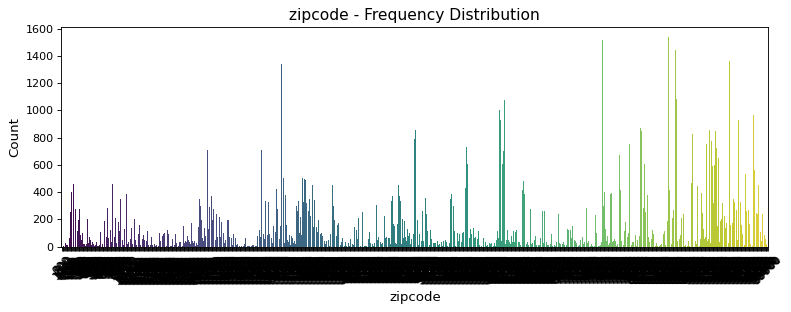

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


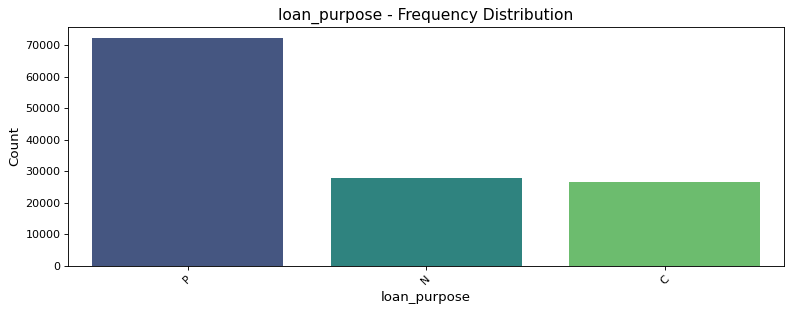

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
/tmp/ipykernel_7531/984660961.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


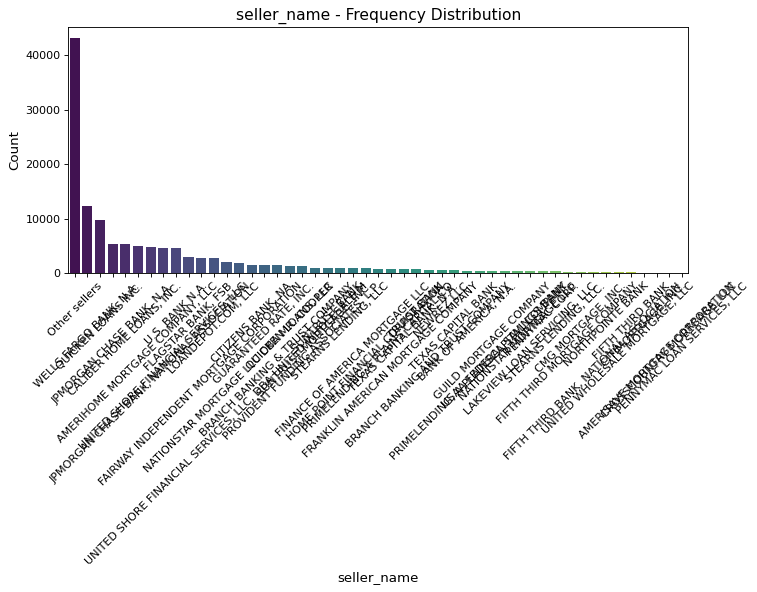

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


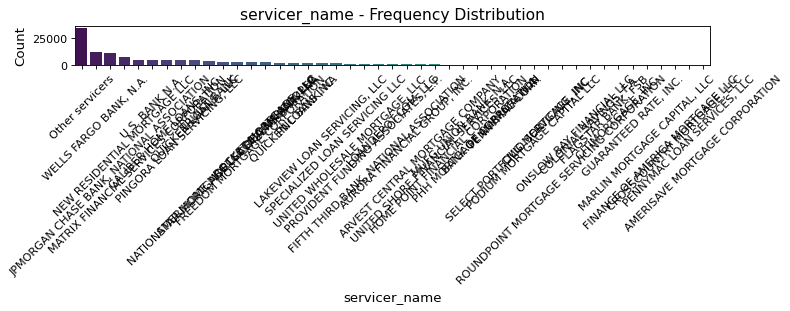

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


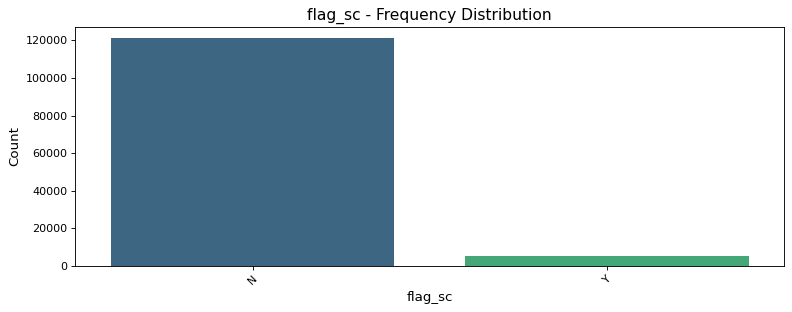

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


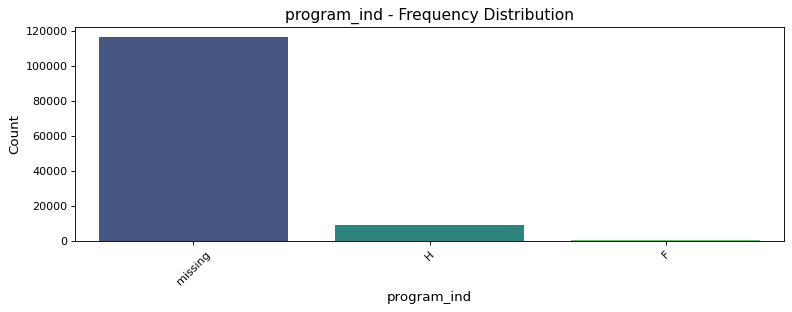

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


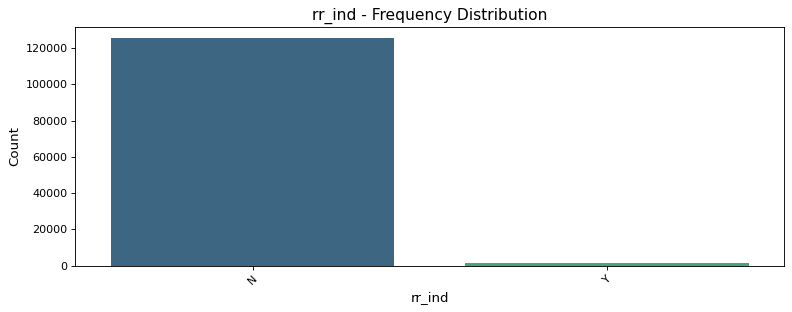

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


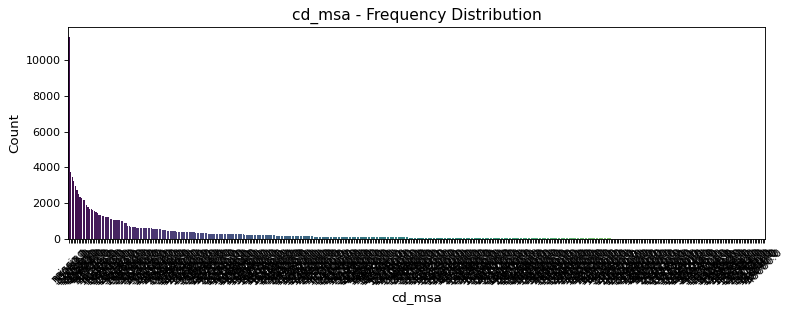

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


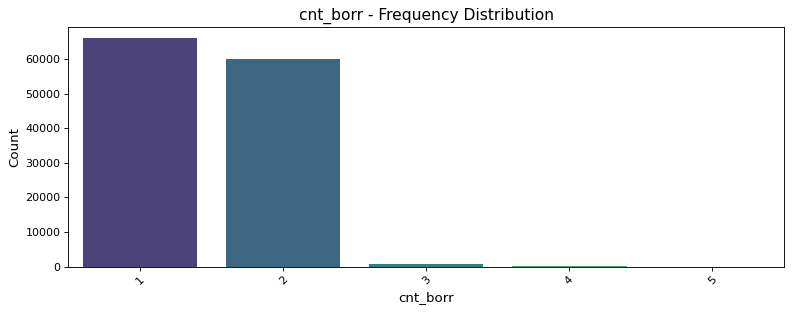

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


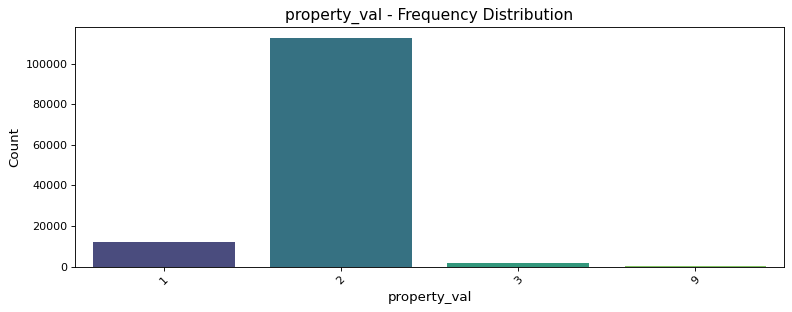

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


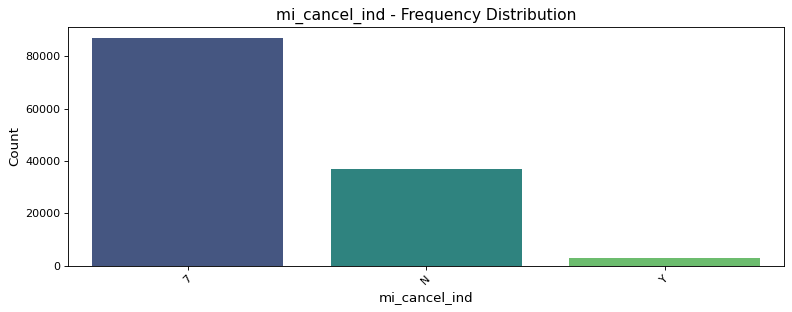

/tmp/ipykernel_7531/984660961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


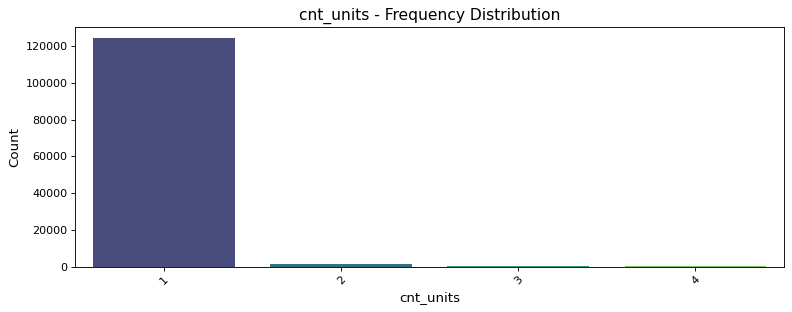

In [13]:
# 该代码块不一定保留
# 类别变量的描述性统计与频数分析
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    
    # 计算每个类别的频数
    value_counts = data_labeled[col].value_counts()
    
    # 绘制条形图
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title(f'{col} - Frequency Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # 如类别名称较长，可以旋转 x 轴标签
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

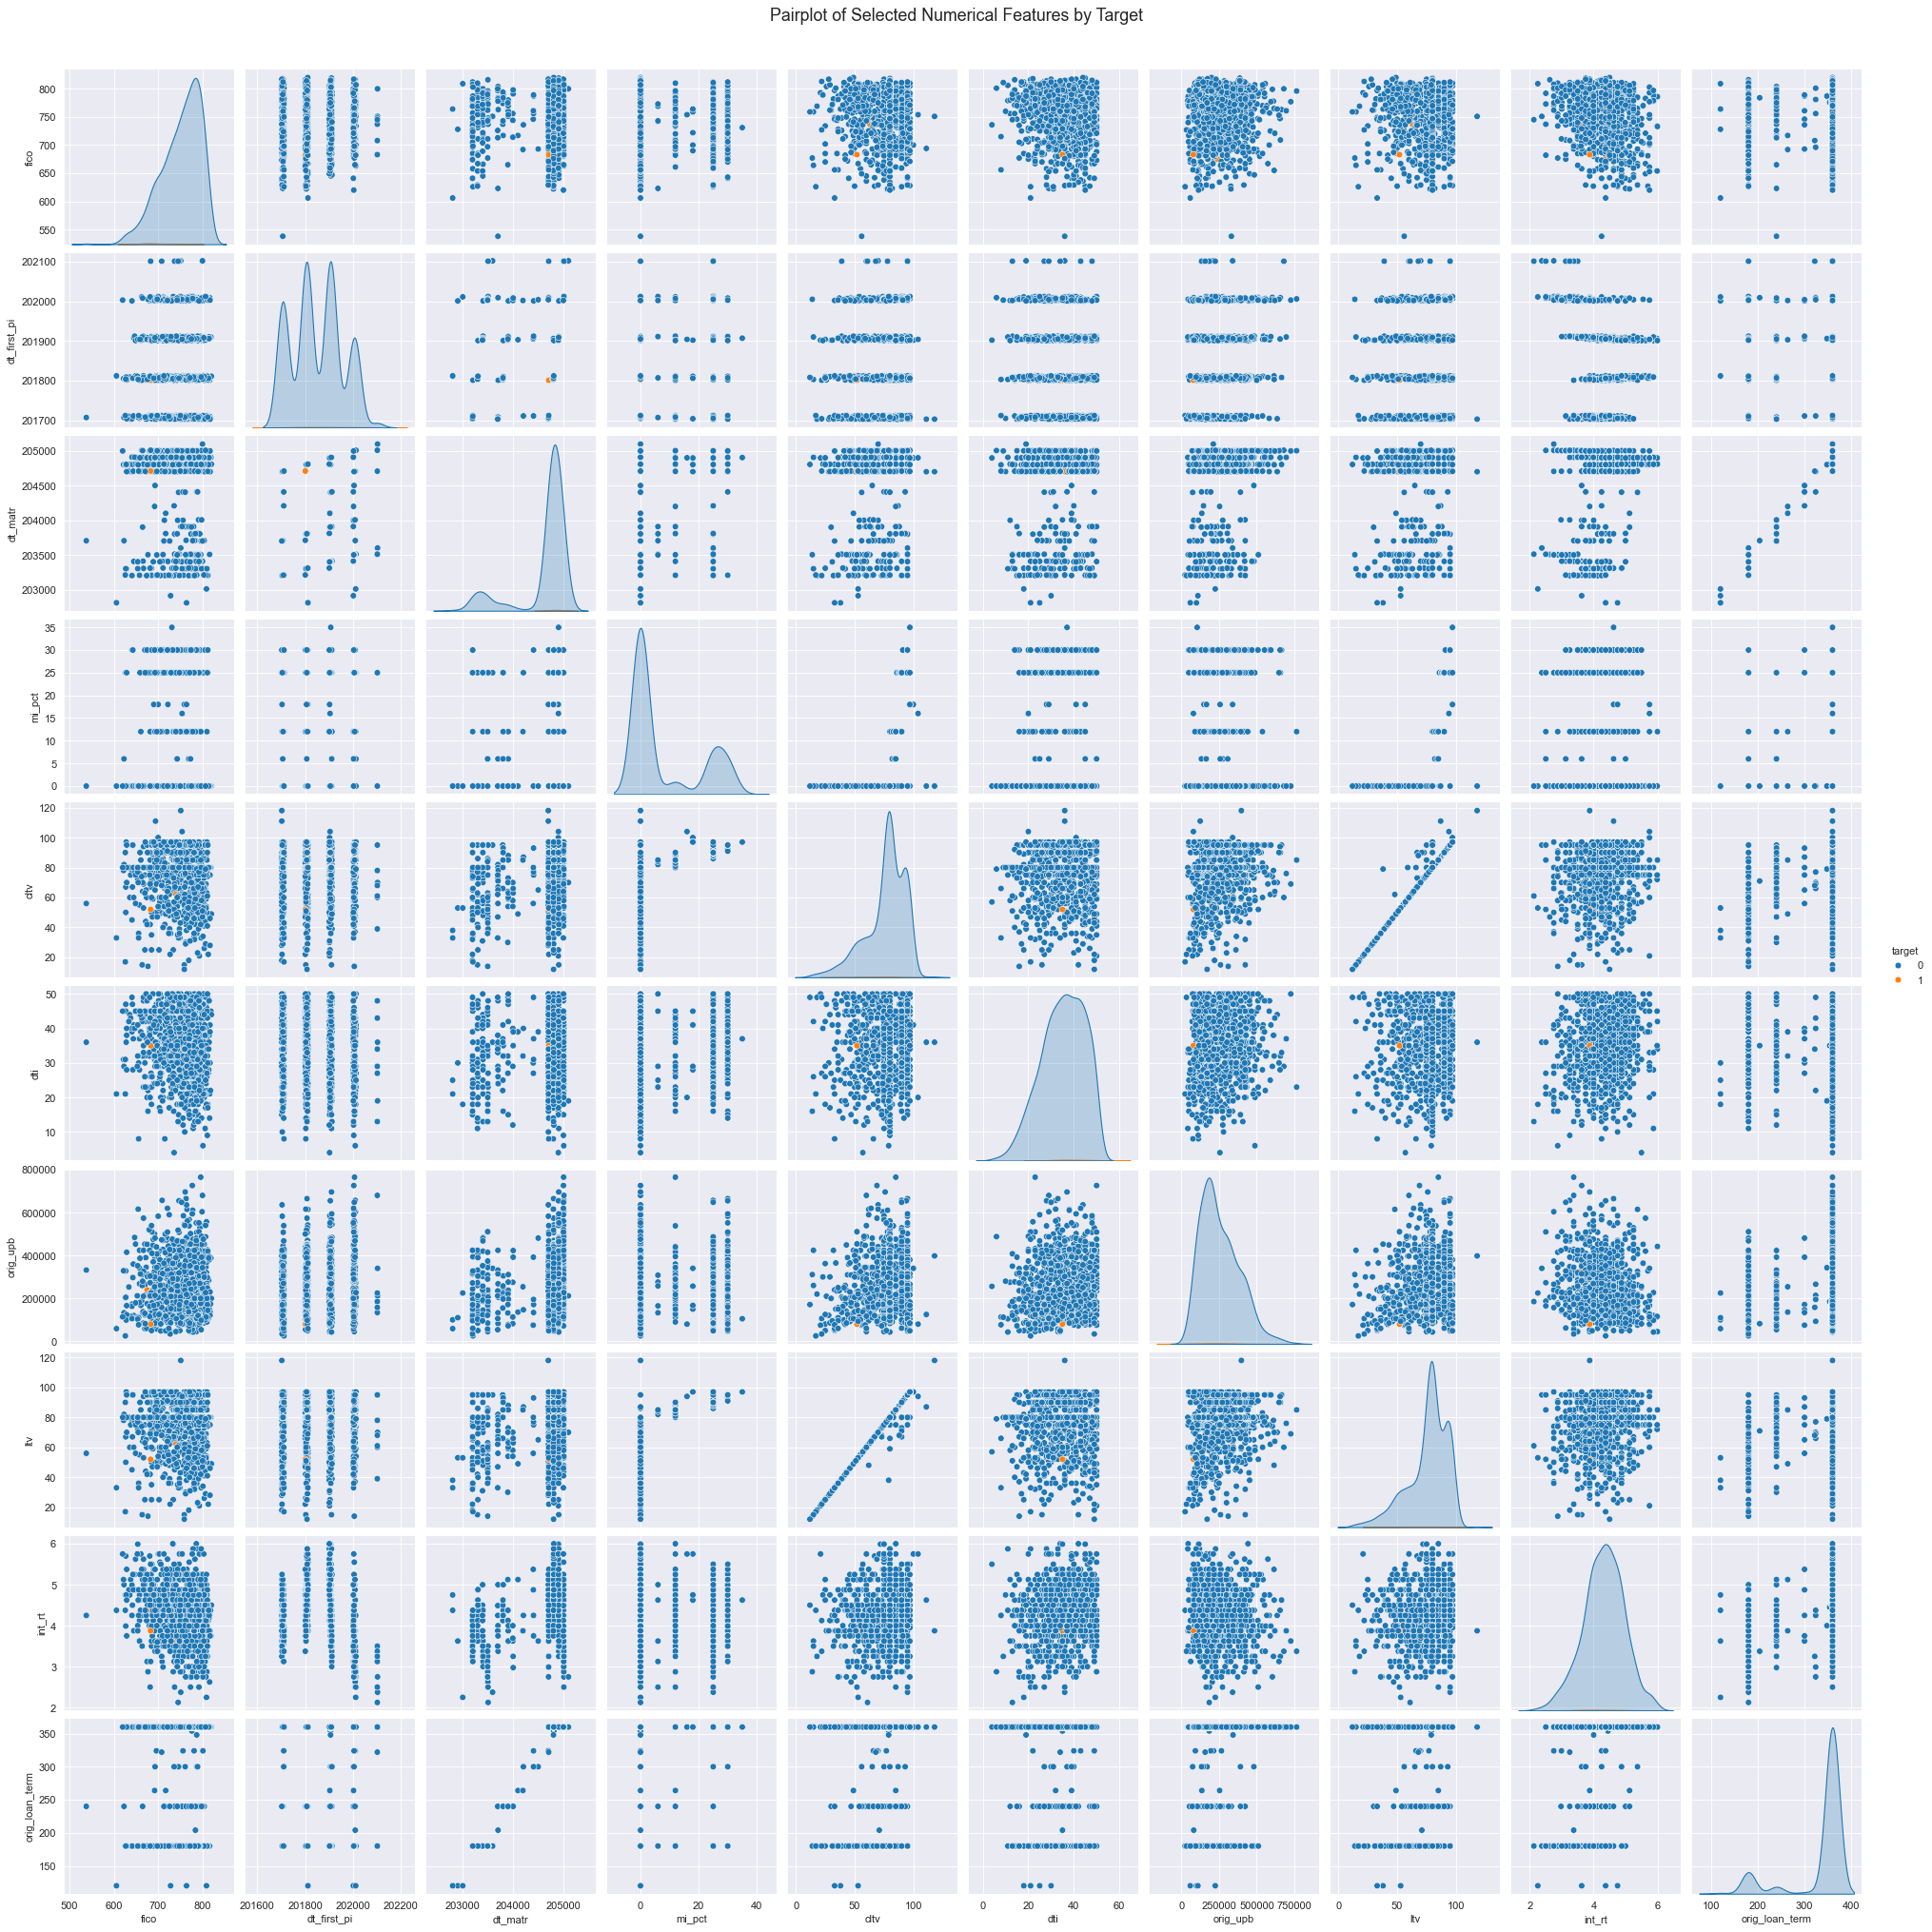

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 选择需要绘制 pairplot 的数值变量并加入 target 列
plot_columns = numerical_columns + ['target']

# 对数据进行采样（例如随机采样 1000 行），避免绘图过于密集和运行时间过长
sampled_data = data_labeled[plot_columns].sample(n=1000, random_state=42)

# 绘制 pairplot，使用 hue 区分 target 类别，diag_kind='kde' 绘制密度图
sns.pairplot(sampled_data, hue='target', diag_kind='kde')

plt.suptitle("Pairplot of Selected Numerical Features by Target", y=1.02, fontsize=16)
plt.show()

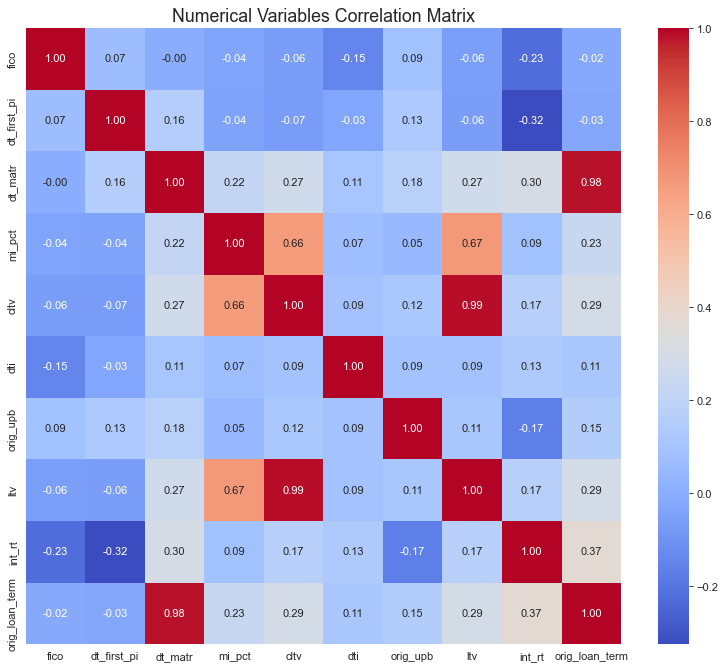

In [37]:
# 计算数值变量之间的皮尔逊相关系数矩阵
corr_matrix = data_labeled[numerical_columns].corr()

# 设置图形尺寸
plt.figure(figsize=(12, 10))

# 使用热力图显示相关矩阵
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")

# 添加图标题
plt.title("Numerical Variables Correlation Matrix", fontsize=16)
plt.show()

Cramér's V between flag_fthb and occpy_sts: 0.18614650492251913
Correlation ratio (η) between flag_fthb and dti: 0.004297006228747019


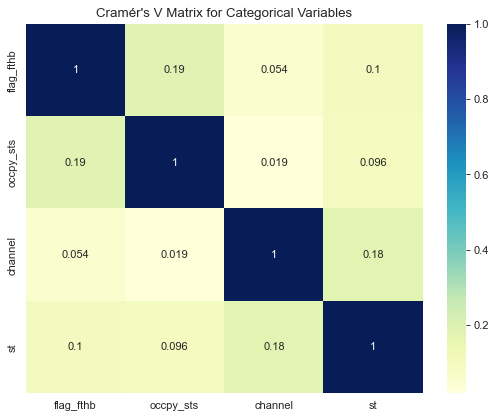

In [38]:
# 该代码块不一定保留
from scipy.stats import chi2_contingency

# ---------------------------
# 1. 计算 Cramér's V (用于类别变量间相关性)
# ---------------------------
def cramers_v(x, y):
    """
    计算两个类别变量的 Cramér's V 值
    参数:
        x, y : pd.Series 或 array-like, 两个类别变量
    返回:
        Cramér's V 值
    """
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.values.sum()
    min_dim = min(contingency_table.shape) - 1
    if min_dim == 0:
        return np.nan
    return np.sqrt(chi2 / (n * min_dim))

# 示例：计算 'flag_fthb' 与 'occpy_sts' 之间的相关性
v_value = cramers_v(data_labeled['flag_fthb'], data_labeled['occpy_sts'])
print("Cramér's V between flag_fthb and occpy_sts:", v_value)

# ---------------------------
# 2. 计算相关比 (Eta 系数，用于数值变量与类别变量间相关性)
# ---------------------------
def correlation_ratio(categories, measurements):
    """
    计算相关比（η），用于衡量分类变量 (categories) 对数值变量 (measurements) 的解释能力。
    参数:
        categories : array-like, 分组变量（类别变量）
        measurements : array-like, 对应的数值变量
    返回:
        η 值，范围为 0 到 1
    """
    categories = np.array(categories)
    measurements = np.array(measurements)
    # 将类别变量转换为数值编码
    fcat, _ = pd.factorize(categories)
    cat_num = np.unique(fcat)
    n_total = len(measurements)
    grand_mean = np.mean(measurements)
    ss_between = sum([np.sum(fcat == cat) * (np.mean(measurements[fcat == cat]) - grand_mean)**2 
                      for cat in cat_num])
    ss_total = np.sum((measurements - grand_mean)**2)
    if ss_total == 0:
        return 0
    eta = np.sqrt(ss_between/ss_total)
    return eta

# 示例：计算 'dti'（数值变量）与 'flag_fthb'（类别变量）之间的相关比
eta_value = correlation_ratio(data_labeled['flag_fthb'], data_labeled['dti'])
print("Correlation ratio (η) between flag_fthb and dti:", eta_value)

# ---------------------------
# 可视化类别变量之间的相关性热力图
# 如果有多个类别变量，可以组合计算 Cramér's V 矩阵并绘制热力图
# 假设我们选取部分类别变量
categorical_vars = ['flag_fthb', 'occpy_sts', 'channel', 'st']

# 构建相关性矩阵
cramers_matrix = pd.DataFrame(np.zeros((len(categorical_vars), len(categorical_vars))),
                              index=categorical_vars, columns=categorical_vars)

for i in categorical_vars:
    for j in categorical_vars:
        cramers_matrix.loc[i, j] = cramers_v(data_labeled[i], data_labeled[j])

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_matrix, annot=True, cmap="YlGnBu")
plt.title("Cramér's V Matrix for Categorical Variables")
plt.show()


In [11]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

In [40]:
# 1. 计算所有数值变量的偏度
skew_values = data_labeled[numerical_columns].skew()
print("各数值变量的偏度：")
print(skew_values)

# 设置偏度阈值，选择偏斜较严重的变量进行变换
skew_threshold = 0.75
skewed_cols = skew_values[abs(skew_values) > skew_threshold].index.tolist()
print("\n偏斜绝对值大于 {} 的变量：".format(skew_threshold))
print(skewed_cols)

各数值变量的偏度：
fico             -0.646121
dt_first_pi       0.210483
dt_matr          -1.825205
mi_pct            1.018283
cltv             -1.015499
dti              -0.485140
orig_upb          0.782370
ltv              -1.012735
int_rt           -0.204700
orig_loan_term   -1.915661
dtype: float64

偏斜绝对值大于 0.75 的变量：
['dt_matr', 'mi_pct', 'cltv', 'orig_upb', 'ltv', 'orig_loan_term']


处理变量 dt_matr ...
变量 dt_matr 转换失败，错误信息：The algorithm terminated without finding a valid bracket. Consider trying different initial points.
处理变量 mi_pct ...


C:\softwares\programmers\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:3408: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\raymo\AppData\Local\Temp\ipykernel_9784\920912910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled[col] = transformed_col
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io,

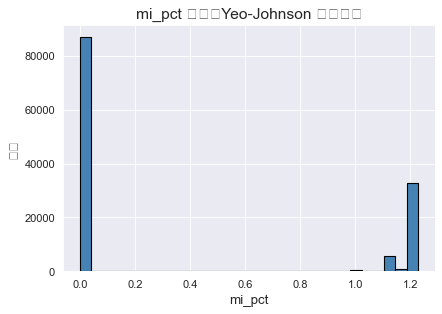

处理变量 cltv ...


C:\Users\raymo\AppData\Local\Temp\ipykernel_9784\920912910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled[col] = transformed_col
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.p

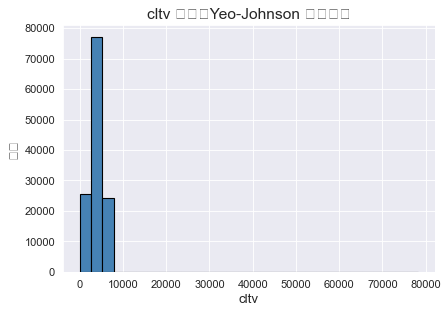

C:\Users\raymo\AppData\Local\Temp\ipykernel_9784\920912910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled[col] = transformed_col


处理变量 orig_upb ...


C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing f

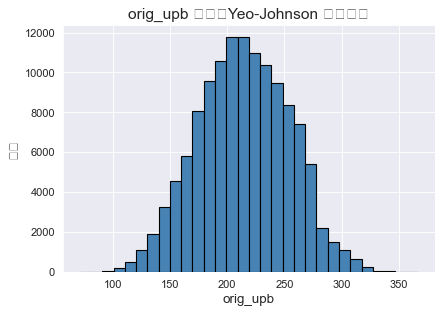

C:\Users\raymo\AppData\Local\Temp\ipykernel_9784\920912910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled[col] = transformed_col
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.p

处理变量 ltv ...


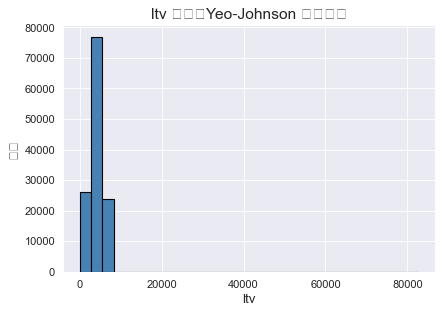

处理变量 orig_loan_term ...


C:\Users\raymo\AppData\Local\Temp\ipykernel_9784\920912910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled[col] = transformed_col
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\softwares\programmers\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.p

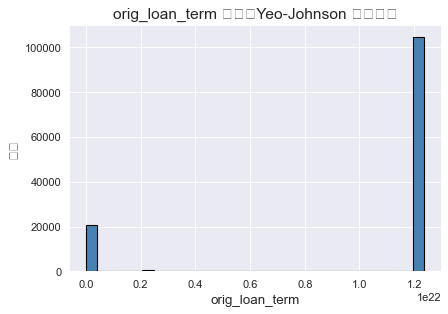

In [41]:
# 2. 针对每个偏斜变量，单独尝试应用 Yeo-Johnson 变换
for col in skewed_cols:
    # 跳过常数列
    if data_labeled[col].nunique() <= 1:
        print(f"变量 {col} 值为常数，跳过转换。")
        continue
    print(f"处理变量 {col} ...")
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    try:
        # 对单个变量进行转换，注意传入二维数组 data_labeled[[col]]
        transformed_col = pt.fit_transform(data_labeled[[col]])
        data_labeled[col] = transformed_col
        # 绘制直方图查看变换后效果
        plt.figure(figsize=(6, 4))
        plt.hist(data_labeled[col], bins=30, color='steelblue', edgecolor='k')
        plt.title(f'{col} 分布（Yeo-Johnson 变换后）', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('频数', fontsize=12)
        plt.show()
    except Exception as e:
        print(f"变量 {col} 转换失败，错误信息：{e}")

In [42]:
# 3. 对所有数值变量进行标准化，适用于后续逻辑回归模型
scaler = StandardScaler()
data_labeled[numerical_columns] = scaler.fit_transform(data_labeled[numerical_columns])

# 检查标准化后均值和标准差
print("\n标准化后各数值变量的均值（应接近0）：")
print(np.round(data_labeled[numerical_columns].mean(), 3))
print("\n标准化后各数值变量的标准差（应接近1）：")
print(np.round(data_labeled[numerical_columns].std(), 3))


标准化后各数值变量的均值（应接近0）：
fico             -0.0
dt_first_pi      -0.0
dt_matr           0.0
mi_pct           -0.0
cltv              0.0
dti              -0.0
orig_upb          0.0
ltv               0.0
int_rt           -0.0
orig_loan_term    0.0
dtype: float64

标准化后各数值变量的标准差（应接近1）：
fico              1.0
dt_first_pi       1.0
dt_matr           1.0
mi_pct            1.0
cltv              1.0
dti               1.0
orig_upb          1.0
ltv               1.0
int_rt            1.0
orig_loan_term    1.0
dtype: float64


C:\Users\raymo\AppData\Local\Temp\ipykernel_9784\2395561101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labeled[numerical_columns] = scaler.fit_transform(data_labeled[numerical_columns])


# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

In [12]:
# 1. 构建用于建模的特征变量和目标变量
# 对类别变量进行独热编码（注意：也可以用其他编码方式）
X = pd.get_dummies(data_labeled[categorical_columns + numerical_columns], drop_first=True)
y = data_labeled['target']

# 2. 划分训练集和测试集（保持 target 分布，使用 stratify 参数）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [14]:
# 3. 构建并拟合逻辑回归模型
# 由于数据存在严重不平衡，设置 class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

: 

In [47]:
# 4. 预测和评估模型
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]

In [48]:
# 输出分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     25192
           1       0.02      0.48      0.03       149

    accuracy                           0.83     25341
   macro avg       0.51      0.65      0.47     25341
weighted avg       0.99      0.83      0.90     25341



In [49]:
# 计算 ROC AUC 分数
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.7353301143859454


In [50]:
# 输出混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[20921  4271]
 [   78    71]]


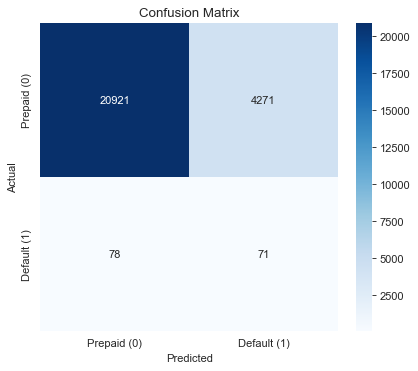

In [51]:
# 5. 绘制混淆矩阵热力图
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prepaid (0)', 'Default (1)'], 
            yticklabels=['Prepaid (0)', 'Default (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def classification_model_fit(model, X_test, y_test, model_name="Model"):
    """
    评估二分类模型的性能并绘制混淆矩阵。
    
    参数：
    model      : 拟合好的 sklearn 分类模型（如逻辑回归）
    X_test     : 测试集特征
    y_test     : 测试集标签（真实值）
    model_name : 可选，显示在图标题上的模型名
    """

    # 获取预测值
    y_pred = model.predict(X_test)
    
    # 获取预测概率（用于 ROC AUC）
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    # 计算评估指标
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"📊 评估指标 ({model_name})")
    print("-" * 30)
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC AUC Score  : {auc:.4f}")

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Prepaid (0)', 'Default (1)']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14)
    plt.show()

    # 可选：返回指标字典
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm
    }


In [52]:
# 假设 confusion_matrix 变量 cm 已经定义，格式如下：
#      预测：0      预测：1
# 实际：0   TN         FP
# 实际：1   FN         TP
TN, FP, FN, TP = cm.ravel()

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print("从混淆矩阵中计算出的各项指标：")
print(f"准确率 (Accuracy): {accuracy:.3f}")
print(f"精确率 (Precision): {precision:.3f}")
print(f"召回率 (Recall/Sensitivity): {recall:.3f}")
print(f"F1 分数: {f1_score:.3f}")
print(f"特异性 (Specificity): {specificity:.3f}")


从混淆矩阵中计算出的各项指标：
准确率 (Accuracy): 0.828
精确率 (Precision): 0.016
召回率 (Recall/Sensitivity): 0.477
F1 分数: 0.032
特异性 (Specificity): 0.830


基模拟合结果解释：
从上述指标来看，模型在总体准确率和特异性上表现尚可，但对默认（违约）的预测效果极差，具体分析如下：

• 整体准确率为 82.8%
　- 这一数值看似较高，但在严重不平衡的数据集中（即违约样本数量远少于预还清样本）准确率往往容易被多数类支配，因此不能单独代表模型对少数类（违约）的有效识别能力。

• 精确率（Precision）仅为 1.6%
　- 当模型预测为违约时，只有 1.6% 的样本实际上是违约。这说明模型产生了大量假阳性（错误地将预还清预测为违约），在实际应用中可能导致大量误报。

• 召回率（Recall/Sensitivity）为 47.7%
　- 在所有实际违约的样本中，模型仅能正确识别 47.7%。虽然召回率相对于精确率来说还算中等，但结合精确率极低来看，说明虽然模型能覆盖部分违约样本，但其信号噪比非常低，基本上未能提供高质量的违约预测。

• F1 分数仅为 0.032
　- 这是精确率和召回率的调和平均值，显示模型在少数类别上的综合性能很差，难以在精确率与召回率之间取得平衡，整体效果极不理想。

• 特异性（Specificity）为 83.0%
　- 表示在预还清（majority 类）样本中，有 83% 被正确识别。这一指标较高，但在严重不平衡的数据中，高特异性对整体表现的提升意义有限，关键是需要改善违约（少数类）的识别性能。

总体而言，尽管模型在整体正确率和多数类别的识别上表现可以，但对于违约这一目标类别——尤其在实际业务场景下通常更为关注其精确识别，模型当前的低精确率和极低的 F1 分数表明模型存在明显问题，可能主要受数据不平衡影响。

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [56]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project2.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", line 390, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", li